### Setup env + imports

In [6]:
# Setup env
# pip install/uv add -> pandas numpy scipy matplotlib scikit-learn statsmodels \ 
# pandas-market-calendars pytz python-dotenv requests finnhub-python alpaca-trade-api py_vollib

In [39]:
# Setup all imports
import os, time, datetime as dt
from datetime import timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import finnhub
from alpaca_trade_api.rest import REST, TimeFrame
import yfinance as yf

from dotenv import load_dotenv

# FinnHub
Here we call Finnhub API to get earnings calendar data, and we call Alpaca API to get actual candlestick data

In [42]:
# helpers
def to_unix(d: dt.datetime) -> int:
    return int(time.mktime(d.timetuple()))

# fetch daily candles in [open, high, low, close, volume] into a df and index by date
def get_daily_candles_finnhub(fh: finnhub.Client, symbol: str, start: dt.datetime, end: dt.datetime) -> pd.DataFrame:
    res = fh.stock_candles(symbol, 'D', to_unix(start), to_unix(end))
    if res.get('s') != 'ok':
        return pd.DataFrame(columns=['open','high','low','close','volume'])

    # create a dtindex with UTC, convert, then drop the tz
    idx = pd.to_datetime(res['t'], unit='s', utc=True) \
            .tz_convert('US/Eastern').tz_localize(None)

    df = pd.DataFrame({
        'open':  res['o'],
        'high':  res['h'],
        'low':   res['l'],
        'close': res['c'],
        'volume':res['v'],
    }, index=idx).sort_index()

    return df
# fetch daily candles in [open, high, low, close, volume] into a df and index by date

def get_daily_candles_alpaca(api: REST, symbol: str, start: dt.datetime, end: dt.datetime) -> pd.DataFrame:
    # Alpaca daily bars: pass date-only strings; end is exclusive → add +1 day
    start_str = start.date().isoformat()
    end_str   = (end.date() + timedelta(days=1)).isoformat()

    bars = api.get_bars(symbol, TimeFrame.Day, start=start_str, end=end_str, adjustment='raw').df
    if bars.empty:
        return pd.DataFrame(columns=['open','high','low','close','volume'])

    # Multi-symbol safety
    if 'symbol' in bars.columns:
        bars = bars[bars['symbol'] == symbol]

    # Index is tz-aware UTC; convert to US/Eastern and drop tz for readability
    bars.index = bars.index.tz_convert('US/Eastern').tz_localize(None)

    # Standardize columns (Alpaca already uses these names, but be explicit)
    cols = ['open','high','low','close','volume']
    return bars[cols].sort_index()

def load_earnings_events_w_augment(fh, symbol: str, want_rows: int = 12) -> pd.DataFrame:
    # 1) Finnhub EPS history
    eps_hist = fh.company_earnings(symbol, limit=60) or []
    eps_df = pd.DataFrame(eps_hist)
    if not eps_df.empty:
        eps_df['date'] = pd.to_datetime(eps_df['period']).dt.tz_localize(None)
        eps_df = eps_df.rename(columns={'estimate':'epsEstimate','actual':'epsActual'})
        eps_df = eps_df[['date','epsEstimate','epsActual','surprise','surprisePercent']]
    else:
        eps_df = pd.DataFrame(columns=['date','epsEstimate','epsActual','surprise','surprisePercent'])

    # 2) yfinance dates (more generous history)
    yfd = yf.Ticker(symbol).get_earnings_dates(limit=40).reset_index()
    yfd = yfd.rename(columns={'Earnings Date':'date'})[['date']]
    yfd['date'] = pd.to_datetime(yfd['date']).dt.tz_localize(None)

    # 3) union dates, then left-join EPS where present
    all_dates = yfd.drop_duplicates('date')
    merged = all_dates.merge(eps_df, on='date', how='left').sort_values('date')

    # 4) (optional) bring in AMC/BMO for recent window
    cal = fh.earnings_calendar(_from=(dt.date.today()-timedelta(days=40)).isoformat(),
                               to=(dt.date.today()+timedelta(days=10)).isoformat(),
                               symbol=symbol) or {}
    cal_df = pd.DataFrame(cal.get('earningsCalendar', []))
    if not cal_df.empty and 'date' in cal_df and 'time' in cal_df:
        cal_df['date'] = pd.to_datetime(cal_df['date']).dt.tz_localize(None)
        merged = merged.merge(cal_df[['date','time']], on='date', how='left')
    
    # Ensure 'time' column always exists
    if 'time' not in merged.columns:
        merged['time'] = np.nan

    return merged.tail(want_rows).reset_index(drop=True)


start date:  1998-05-31 , end_date:  2025-10-23
                  date  epsEstimate  epsActual  surprise  surprisePercent  \
7  2024-04-11 16:05:00          NaN        NaN       NaN              NaN   
8  2024-08-28 16:15:00          NaN        NaN       NaN              NaN   
9  2024-10-09 16:05:00          NaN        NaN       NaN              NaN   
10 2025-01-14 16:05:00          NaN        NaN       NaN              NaN   
11 2025-04-14 16:05:00          NaN        NaN       NaN              NaN   

    time  
7    NaN  
8    NaN  
9    NaN  
10   NaN  
11   NaN  
                  date  epsEstimate  epsActual
0  2022-08-25 16:05:00          NaN        NaN
1  2022-10-11 16:05:00          NaN        NaN
2  2023-01-09 16:05:00          NaN        NaN
3  2023-04-06 08:00:00          NaN        NaN
4  2023-07-24 08:00:00          NaN        NaN
5  2023-10-09 08:00:00          NaN        NaN
6  2024-01-16 08:11:00          NaN        NaN
7  2024-04-11 16:05:00          NaN        NaN


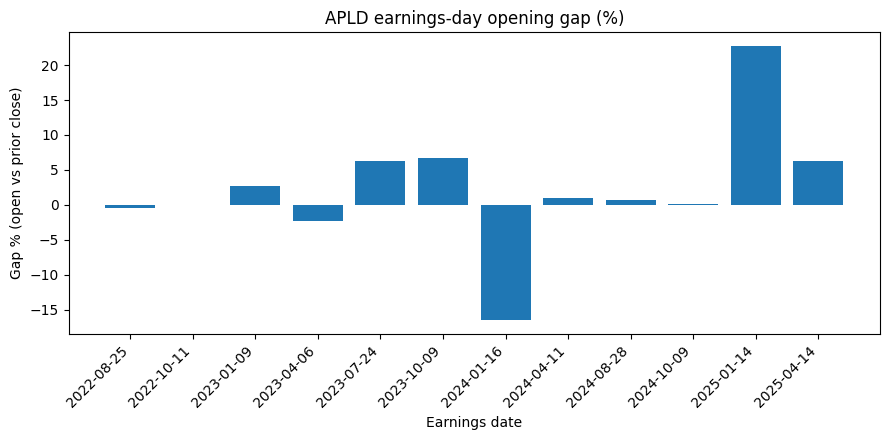

No EPS surprise data available from the calendar payload for these dates.


In [43]:
# Config for now with APLD 
load_dotenv()
SYMBOL = "APLD" # change to array of symbols next time
LOOKBACK_DAYS = 10000
MAX_EARNINGS = 12

FH_API_KEY = os.getenv("FINNHUB_API_KEY")

ALPACA_KEY = os.getenv("ALPACA_API_KEY")
ALPACA_SECRET = os.getenv("ALPACA_API_SECRET")
BASE_URL = "https://paper-api.alpaca.markets"

alpaca = REST(ALPACA_KEY, ALPACA_SECRET, BASE_URL) # type: ignore
fh = finnhub.Client(api_key=FH_API_KEY)

# 1) pull earnings calendar (past + upcoming window)
today = dt.date.today()
start_date = (today - timedelta(days=LOOKBACK_DAYS)).isoformat()
end_date   = (today + timedelta(days=7)).isoformat()  # include near-future in case an event is imminent
print("start date: ", start_date, ", end_date: ", end_date)

ec = fh.earnings_calendar(_from=start_date, to=end_date, symbol=SYMBOL) or {}
# events = pd.DataFrame(ec.get('earningsCalendar', []))
events = load_earnings_events_w_augment(fh, SYMBOL, want_rows=MAX_EARNINGS)
print(events.tail())

if events.empty:
    raise RuntimeError("No earnings from finnhub in the selected range. Try increasing LOOKBACK_DAYS.")

# keep only the latest N events (historical first)
events['date'] = pd.to_datetime(events['date'])
events = events.sort_values('date').tail(MAX_EARNINGS).reset_index(drop=True)

print(events[['date','epsEstimate','epsActual']])

# 2) compute earnings-day gap vs prior close
gap_rows = []
price_windows = {}  # optional: cache per period

for _, row in events.iterrows():
    d = row['date'].date()

    win_start = dt.datetime.combine(d - timedelta(days=5), dt.time(0,0))
    win_end   = dt.datetime.combine(d + timedelta(days=2), dt.time(0,0))
    candles = get_daily_candles_alpaca(alpaca, symbol=SYMBOL, start=win_start, end=win_end)
    if candles.empty:
        continue

    # base position: first trading day on/after the calendar date
    pos = int(candles.index.searchsorted(pd.Timestamp(d)))

    # adjust for timing label: 'amc' → next trading session’s open
    time_label = str(row.get('time', '')).lower()
    if time_label == 'amc':
        pos += 1
    # for 'bmo' we keep pos as-is (same day’s open)

    # bounds & "need a previous close" guard
    if pos <= 0 or pos >= len(candles):
        continue

    prev_close = float(candles.iloc[pos - 1]['close'])
    curr_open  = float(candles.iloc[pos]['open'])
    idx_e = candles.index[int(pos)]  # DatetimeIndex → Timestamp
    gap_pct = (curr_open - prev_close) / prev_close * 100.0

    gap_rows.append({
        'date': idx_e.date(),
        'prev_close': prev_close,
        'open_on_earn': curr_open,
        'gap_pct': gap_pct,
        'eps_est': row.get('epsEstimate', np.nan),
        'eps_act': row.get('epsActual', np.nan),
        'surprise': row.get('surprise', np.nan),
        'surprise_pct': row.get('surprisePercent', np.nan),
        'time_label': time_label or np.nan,   # helpful for debugging
    })

gaps = pd.DataFrame(gap_rows)
print("Earnings gaps:")
print(gaps)

# 3) plot: earnings-day gap %
plt.figure(figsize=(9,4.5))
plt.bar(gaps['date'].astype(str), gaps['gap_pct'])
plt.title(f"{SYMBOL} earnings-day opening gap (%)")
plt.xlabel("Earnings date")
plt.ylabel("Gap % (open vs prior close)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 4) plot: EPS surprise (if available)
if 'surprise' in gaps and gaps['surprise'].notna().any():
    plt.figure(figsize=(9,4.5))
    plt.bar(gaps['date'].astype(str), gaps['surprise'])
    plt.title(f"{SYMBOL} EPS surprise (actual - estimate)")
    plt.xlabel("Earnings date")
    plt.ylabel("EPS surprise")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No EPS surprise data available from the calendar payload for these dates.")